In [1]:
import numpy as np
import torch

import autograd
from autograd import backend

import graphviz

In [2]:
# OR Gate
xs = [[0, 0], [0, 1], [1, 0], [1, 1]]
ys = [0, 1, 1, 1]

# Torch OR Gate
txs = torch.tensor(xs)
tys = torch.tensor(ys)

In [3]:
class AutogradManualModel:
    def __init__(self, nin, layer_dims=[3,4,1], activation='relu'):
        self.nin = nin
        self.layer_dims = [nin] + layer_dims
        self.w = []
        for i in range(1, len(self.layer_dims)):
            self.w.append([[autograd.Variable(np.random.uniform(-0.1, 0.1)) for i in range(self.layer_dims[i-1])] for _ in range(self.layer_dims[i])])
        
        self.b = [autograd.Variable(np.random.uniform(-0.1, 0.1)) for i in range(len(layer_dims))]


        # self.w shape: (num_layers, num_neurons)
        # self.b shape: (num_layers,1)


        if activation == 'relu':
            self.activation = autograd.relu
        elif activation == 'sigmoid':
            self.activation = autograd.atomic_sigmoid
        else:
            raise ValueError(f'available activations (relu, sigmoid). Recieved: {activation}')

    @property
    def weights(self):
        return backend.flatten(self.w)
    
    @property
    def biases(self):
        return backend.flatten(self.b)


    def __call__(self, x):
        inputs = x

        # Define the graph
        current_operations = []

        # loop over every layer
        for i, (layer_weights, layer_biases) in enumerate(zip(self.w, self.b)):
            # loop over the layer neurons
            for curr_w in layer_weights:
                # we do not want to add sigmoid to the last layer
                if i != len(self.w) - 1:
                    # loop over each neuron and multiply it with each feature in the input
                    out = sum([self.activation((w * inp) + layer_biases) for w, inp in zip(curr_w, inputs)])
                else:
                    out = sum([(w * inp) + layer_biases for w, inp in zip(curr_w, inputs)])
                # store the operations
                current_operations.append(out)
            # store them in inputs so we can process them in the next iteration
            inputs = current_operations
            current_operations = []

        return out


In [4]:
class TorchManualModel:
    def __init__(self, nin, layer_dims=[3,4,1], activation='relu'):
        self.nin = nin
        self.layer_dims = [nin] + layer_dims
        self.w = []
        for i in range(1, len(self.layer_dims)):
            self.w.append([[torch.tensor(np.random.uniform(-0.1, 0.1), requires_grad=True) for i in range(self.layer_dims[i-1])] for _ in range(self.layer_dims[i])])
        
        self.b = [torch.tensor(np.random.uniform(-0.1, 0.1), requires_grad=True) for i in range(len(layer_dims))]

        if activation == 'relu':
            self.activation = torch.relu
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid
        else:
            raise ValueError(f'available activations (relu, sigmoid). Recieved: {activation}')
    
    @property
    def weights(self):
        return backend.flatten(self.w)
    
    @property
    def biases(self):
        return backend.flatten(self.b)


    def __call__(self, x):
        inputs = x
        current_operations = []
        for i, (layer_weights, layer_biases) in enumerate(zip(self.w, self.b)):
            for curr_w in layer_weights:
                # we do not want to add sigmoid to the last layer
                if i != len(self.w) - 1:
                    out = sum([self.activation((w * inp) + layer_biases) for w, inp in zip(curr_w, inputs)])
                else:
                    out = sum([(w * inp) + layer_biases for w, inp in zip(curr_w, inputs)])
                current_operations.append(out)
            inputs = current_operations
            current_operations = []
        return out

In [5]:
aml = AutogradManualModel(2, [5, 5, 1], 'relu')
tml = TorchManualModel(2, [5, 5, 1], 'relu')

In [6]:
# set the weights to be the same
# in pytorch and autograd.

for torch_weight, autograd_weight in zip(backend.flatten(tml.w), backend.flatten(aml.w)):
    torch_weight.data = torch.tensor(autograd_weight.data)
    torch_weight.requires_grad = True

for torch_bias, autograd_bias in zip(tml.b, aml.b):
    torch_bias.data = torch.tensor(autograd_bias.data)
    torch_bias.requires_grad = True

In [7]:
def train(autograd_model, torch_model, epochs=5):
    lr = 0.01
    for i in range(1, epochs+1):
        outs = []
        for x in xs:
            out = autograd_model(x)
            outs.append(out)

        # for clarity and auto-completion
        loss: autograd.Node = None
        for o, y in zip(outs, ys):
            if loss is None:
                loss = (y - o)**2
            else:
                loss += (y - o)**2
        
        loss = loss / len(ys)

        loss_val = loss.forward()
        print(f'Epoch {i}: autograd_loss_val={loss_val: .4f}', end='  ')
        
        loss.backward(autograd_model.w)
        loss.backward(autograd_model.b)

        # Here we do not need to implement something like `zero_grad()` 
        # because in autograd the gradients are set to `zero` every `backward` call.
        for w in autograd_model.weights:
            w._data += -lr * w.gradients

            # Here we should reset the graph of the weights
            # because it will be re-constructed in every call
            # this behaviour can be disabled if we replaced the input
            # layer with a placeholder and process the inputs batch by batch
            # otherwise if we sent multiple inputs independetly the graph values 
            # from the past inputs will be overwritten by the new passed inputs
            w.outcoming_nodes = []
        
        for b in autograd_model.biases:
            b._data += -lr * b.gradients
            b.outcoming_nodes = []

        # instead of doing w.outcoming_nodes = [] and b.outcoming_nodes = []
        # you can call these functions:
        # backend.reset_weights_graph(autograd_model.w)
        # backend.reset_weights_graph(autograd_model.b)

        torch_outs = []
        for x in xs:
            out = tml(x)
            torch_outs.append(out)

        # for clarity and auto-completion
        torch_loss: torch.Tensor = None
        for o, y in zip(torch_outs, ys):
            if torch_loss is None:
                torch_loss = (y - o)**2
            else:
                torch_loss += (y - o)**2
        
        torch_loss = torch_loss / len(ys)

        torch_loss.backward(retain_graph=True)
        print(f'torch_loss_val={torch_loss.item(): .4f}')


        weights = backend.flatten(torch_model.w)
        biases = backend.flatten(torch_model.b)

        for w in weights:
            w.data += -lr * w.grad
            # equivalent to `model.zero_grad(set_to_none=True)` or `optimizer.zero_grad(set_to_none=True)`
            w.grad = None
        
        for b in biases:
            b.data += -lr * b.grad
            # equivalent to `model.zero_grad(set_to_none=True)` or `optimizer.zero_grad(set_to_none=True)`
            b.grad = None

In [8]:
train(aml, tml)

Epoch 1: autograd_loss_val= 1.5657  torch_loss_val= 1.5657
Epoch 2: autograd_loss_val= 0.4877  torch_loss_val= 0.4877
Epoch 3: autograd_loss_val= 0.2484  torch_loss_val= 0.2484
Epoch 4: autograd_loss_val= 0.1993  torch_loss_val= 0.1993
Epoch 5: autograd_loss_val= 0.1897  torch_loss_val= 0.1897


In [9]:
graph = graphviz.Digraph()

In [10]:
graph.graph_attr['rankdir'] = 'LR'  
graph.edge_attr.update(arrowhead='vee', arrowsize='2')

In [11]:
inputs = [autograd.Variable(x, name=f'variable_{x}') for x in xs[1]]

In [12]:
backend.reset_weights_graph(aml.w)
backend.reset_weights_graph(aml.b)

In [13]:
out = aml(inputs)

In [14]:
loss = autograd.power(out - autograd.Variable(ys[1]), 2, name='loss_function')

In [15]:
def traverse_from_inputs(inp):
    l = []
    def _traverse_from_inputs(inp):
        for i in inp.outcoming_nodes:
            if (i, inp) in l:
                l.remove((i, inp))
                l.append((i, inp))
            else:
                l.append((i, inp))
            _traverse_from_inputs(i)
    _traverse_from_inputs(inp)
    return l

In [16]:
for inp in inputs:
    l = traverse_from_inputs(inp)
    for i, j in l:
        graph.edge(j.name, i.name)

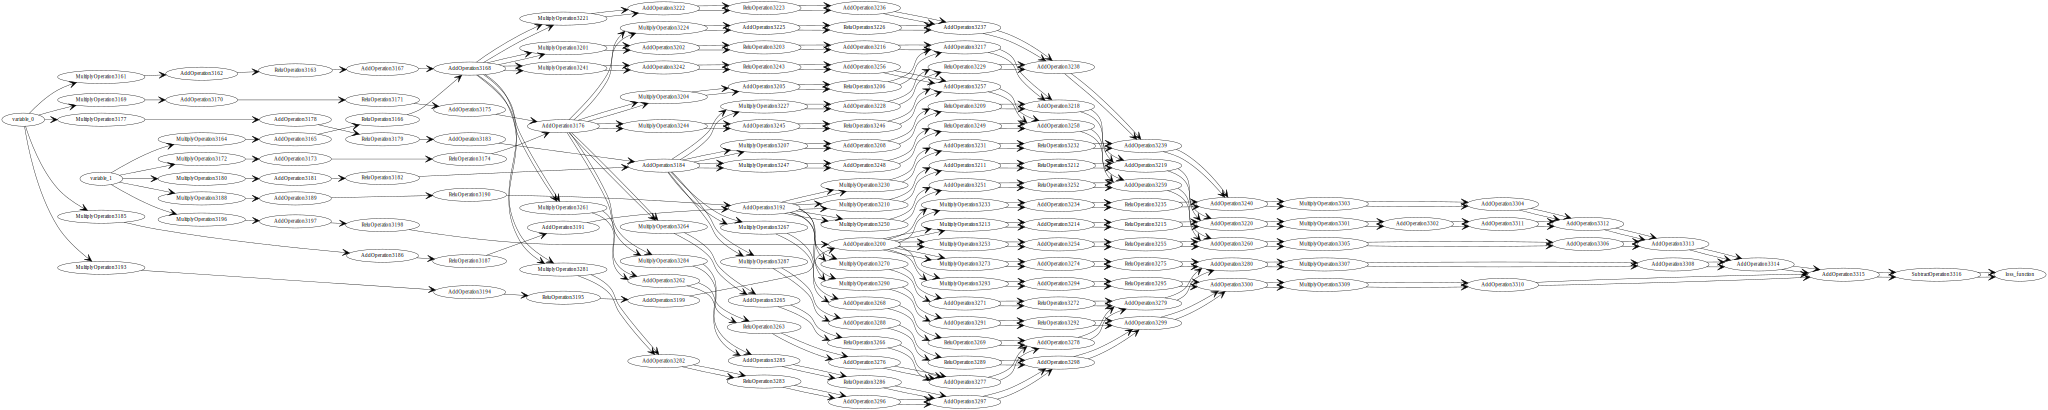

In [17]:
graph